# You Only Look Once (YOLO)

In class, you have learnt about how convolutional neural networks (CNNs) are commonly used to analyze visual imagery. CNNs are known to be shift-invariance based on the weight-sharing architecture of convolutional kernels which slide along input features and provide translational equivariant responses. In previous assignments, we have used CNNs for **object classification** to identify the class of one object in a simple image. In this notebook, we will explore how CNNs can be used for **object detection** in the case where multiple relevant objects are present in a single image. 

Prior work on object detection repurposes classifiers on sliding windows to perform detection, which is slow and expensive for real-time inference demanding detectors for 45 frames per second. The paper ["You Only Look Once: Unified, Real-Time Object Detection"](https://arxiv.org/abs/1506.02640) explores an extremely fast method YOLOv1 which elegantly frames object detection as a regression problem. In this notebook, we will investigate YOLOv3, which is the most accessible version at this time. 

Before YOLO, object detectors were created by repurposing image classifiers to perform localization and detection either by sliding window or regional proposals (i.e. R-CNN). In the spirit of improving inference speed with high sensitivity, YOLO is the first of its kind to formulate object detection as a regression problem to spatially separated bounding boxes and associated class probabilities. The entire multi-object detection pipeline is a single neural network which can be optimized end-to-end directly on detection performance. Thus, YOLO aims to eliminate the need for slow complex image detection pipelines to support real-time inference with streaming video. Further, unlike sliding window or regional proposal methods, YOLO predicts using the entire image so it leverages richer contextual information for better performance. 

As depicted by the figure from the paper below, YOLO is designed to unify two components of image detection: bounding box prediction and object class prediction. To accomplish this, YOLO divides the image into an $S \times S$ grid, where each grid cell predicts $B$ bounding boxes with corresponding confidence scores and $C$ conditional class probabilities. More specifically each bounding box prediction is a 5-tuple $(x,y,w,h,\text{confidence})$, where the $w \times h$ bounding box is centered at $(x,y)$. 

**Figure 2: The Model** from YOLO paper
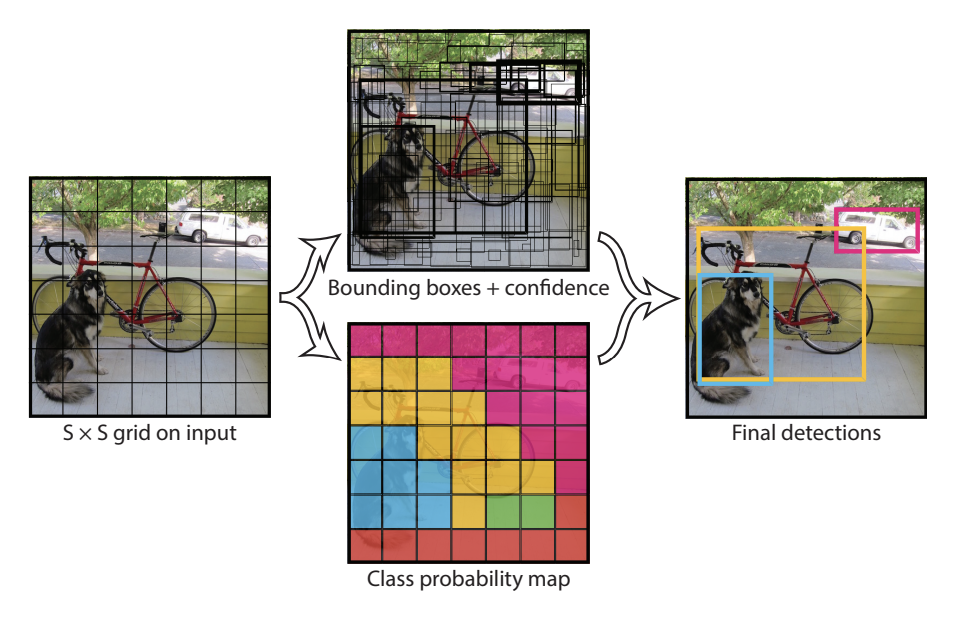

Let's download YOLOv3 and build the model from the paper's original [source code](https://github.com/pjreddie/darknet.git).

In [1]:
import os
import shutil
import cv2
import numpy as np
import matplotlib.pyplot as plt
import torch
from torchvision.utils import draw_bounding_boxes

In [2]:
!git clone https://github.com/pjreddie/darknet.git

Cloning into 'darknet'...
remote: Enumerating objects: 5955, done.
remote: Total 5955 (delta 0), reused 0 (delta 0), pack-reused 5955
Receiving objects: 100% (5955/5955), 6.37 MiB | 6.75 MiB/s, done.
Resolving deltas: 100% (3931/3931), done.


In [3]:
os.chdir("/content/darknet/")
!make

mkdir -p obj
mkdir -p backup
mkdir -p results
gcc -Iinclude/ -Isrc/ -Wall -Wno-unused-result -Wno-unknown-pragmas -Wfatal-errors -fPIC -Ofast -c ./src/gemm.c -o obj/gemm.o
gcc -Iinclude/ -Isrc/ -Wall -Wno-unused-result -Wno-unknown-pragmas -Wfatal-errors -fPIC -Ofast -c ./src/utils.c -o obj/utils.o
In file included from /usr/include/string.h:495,
                 from ./src/utils.c:3:
In function ‘strncpy’,
    inlined from ‘copy_string’ at ./src/utils.c:426:5:
/usr/include/x86_64-linux-gnu/bits/string_fortified.h:106:10: warning: ‘__builtin_strncpy’ specified bound depends on the length of the source argument [-Wstringop-overflow=]
  106 |   return __builtin___strncpy_chk (__dest, __src, __len, __bos (__dest));
      |          ^~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
./src/utils.c: In function ‘copy_string’:
./src/utils.c:426:22: note: length computed here
  426 |     strncpy(copy, s, strlen(s)+1);
      |                      ^~~~~~~~~
gcc -Iinclude/ -Isrc/ -Wa

In [22]:
def show_prediction(file):
  fig,ax = plt.subplots()
  ax.tick_params(labelbottom="off",bottom="off")
  ax.tick_params(labelleft="off",left="off")
  ax.set_xticklabels([]) 
  ax.axis('off')
  
  if os.path.exists(file):
    img = cv2.imread(file)
    show_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) 
    plt.imshow(show_img)

Now we will load in a pre-trained YOLOv3-tiny model and visualize the prediction. We have an image with multiple objects: a person, a horse, and a dog!

In [19]:
!wget https://pjreddie.com/media/files/yolov3-tiny.weights

--2023-04-25 05:28:34--  https://pjreddie.com/media/files/yolov3-tiny.weights
Resolving pjreddie.com (pjreddie.com)... 128.208.4.108
Connecting to pjreddie.com (pjreddie.com)|128.208.4.108|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 35434956 (34M) [application/octet-stream]
Saving to: ‘yolov3-tiny.weights’

yolov3-tiny.weights 100%[===================>]  33.79M  28.2MB/s    in 1.2s    

2023-04-25 05:28:35 (28.2 MB/s) - ‘yolov3-tiny.weights’ saved [35434956/35434956]



In [25]:
!./darknet detect cfg/yolov3-tiny.cfg yolov3-tiny.weights data/person.jpg

layer     filters    size              input                output
    0 conv     16  3 x 3 / 1   416 x 416 x   3   ->   416 x 416 x  16  0.150 BFLOPs
    1 max          2 x 2 / 2   416 x 416 x  16   ->   208 x 208 x  16
    2 conv     32  3 x 3 / 1   208 x 208 x  16   ->   208 x 208 x  32  0.399 BFLOPs
    3 max          2 x 2 / 2   208 x 208 x  32   ->   104 x 104 x  32
    4 conv     64  3 x 3 / 1   104 x 104 x  32   ->   104 x 104 x  64  0.399 BFLOPs
    5 max          2 x 2 / 2   104 x 104 x  64   ->    52 x  52 x  64
    6 conv    128  3 x 3 / 1    52 x  52 x  64   ->    52 x  52 x 128  0.399 BFLOPs
    7 max          2 x 2 / 2    52 x  52 x 128   ->    26 x  26 x 128
    8 conv    256  3 x 3 / 1    26 x  26 x 128   ->    26 x  26 x 256  0.399 BFLOPs
    9 max          2 x 2 / 2    26 x  26 x 256   ->    13 x  13 x 256
   10 conv    512  3 x 3 / 1    13 x  13 x 256   ->    13 x  13 x 512  0.399 BFLOPs
   11 max          2 x 2 / 1    13 x  13 x 512   ->    13 x  13 x 512
   12 con

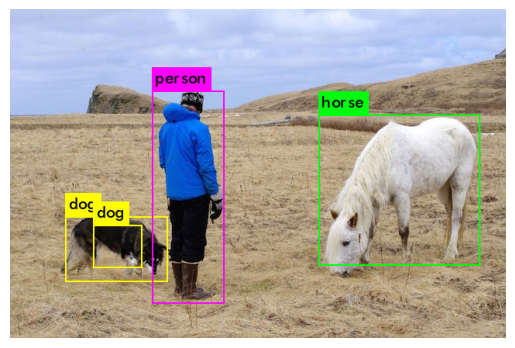

In [26]:
show_prediction('/content/darknet/predictions.jpg')

Notice how the car was predicted twice in the above image. This is a common problem with Object Detection models. Object detection models typically generate multiple candidate boxes and probability levels for each box. A common technique to remedy this is non-maximal supression. In the cells below, we ask you to implement a simple version of NMS.

In [16]:
class BoundingBox:
  def __init__(self, label, probability, xmin, ymin, xmax, ymax):
    self.label = label
    self.p = probability
    self.xmin = xmin
    self.ymin = ymin
    self.xmax = xmax
    self.ymax = ymax

  def area(self):
    return (self.xmax - self.xmin) * (self.ymax - self.ymin)

  def Intersection(self, other):
    if self.xmin > other.xmax or other.xmin > self.xmax \
    or self.ymin > other.ymax or other.ymin > self.ymax:
      return 0.0 # boxes don't intersect
    xmin = max(self.xmin, other.xmin)
    xmax = min(self.xmax, other.xmax)
    ymin = max(self.ymin, other.ymin)
    ymax = min(self.ymax, other.ymax)
    return (xmax - xmin) * (ymax - ymin)

  def Union(self, other):
    return self.area() + other.area() - self.Intersection(other)

  def IOU(self, other):
    return self.Intersection(other) / self.Union(other)

  def toTensor(self):
    return torch.Tensor((self.xmin, self.ymin, self.xmax, self.ymax))


def NMS(boxes, IOU_thresh, threshold):
  """
  Input: 
    boxes = A list of bounding boxes
    IOU_thresh = if two boxes with same label 
    have an IOU above this threshold, discard the less confident box
    threhold = the confidence threshold a box must reach to be considered a hit
  Output: A list of bounding boxes with NMS applied
  """
  ### YOUR CODE HERE
  out = []
  boxes = [box for box in boxes if box.p > threshold]
  while boxes:
    chosen = boxes.pop(0)
    boxes = [box for box in boxes \
             if box.label != chosen.label \
             or box.IOU(chosen) < IOU_thresh]
    out.append(chosen)
  return out
  ### END OF YOUR CODE

Test your implementation by running the snippet below

number of boxes before NMS 30


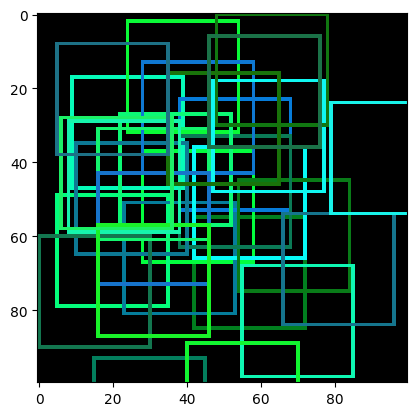

number of boxes after NMS 15


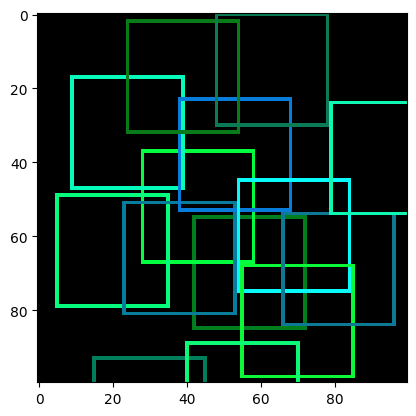

Test Case Passed!


In [17]:
def showBoxes(boxes):
  img = torch.zeros((3,100,100), dtype=torch.uint8)
  boxes_tensors = torch.stack([box.toTensor() for box in boxes], dim=0)
  img = draw_bounding_boxes(img, boxes_tensors)
  plt.imshow(img.numpy().transpose((1,2,0)))
  plt.show()

def testNMS():
  IOU_thresh = 0.3
  thresh = 0.5
  boxes = []
  for i in range(30):
    xmin, xmax = np.random.uniform(0, 100, 2)
    ymin, ymax = np.random.uniform(0, 100, 2)
    if xmin > xmax:
      xmin, xmax = xmax, xmin
    if ymin > ymax:
      ymin, ymax = ymax, ymin
    xmax = xmin + 30
    ymax = ymin + 30
    confidence = np.random.uniform(0.6,1)
    label = np.random.uniform(0,1) > 0.5  # binary label for simplicty
    label = 1
    boxes.append(BoundingBox(label, confidence, xmin, ymin, xmax, ymax))
  print(f"number of boxes before NMS {len(boxes)}")
  showBoxes(boxes)
  nms_boxes = NMS(boxes, IOU_thresh, thresh)
  print(f"number of boxes after NMS {len(nms_boxes)}")
  showBoxes(nms_boxes)
  return True

assert testNMS()

print("Test Case Passed!")

Note that we can also train the model from scratch using custom data! Below is code that will train the YOLOv3-tiny model on the PASCAL VOC dataset. We will first download and label the data, then train. 

In [ ]:
!wget https://pjreddie.com/media/files/VOCtrainval_11-May-2012.tar
!wget https://pjreddie.com/media/files/VOCtrainval_06-Nov-2007.tar
!wget https://pjreddie.com/media/files/VOCtest_06-Nov-2007.tar
!tar xf VOCtrainval_11-May-2012.tar
!tar xf VOCtrainval_06-Nov-2007.tar
!tar xf VOCtest_06-Nov-2007.tar

--2023-04-25 02:43:17--  https://pjreddie.com/media/files/VOCtrainval_11-May-2012.tar
Resolving pjreddie.com (pjreddie.com)... 128.208.4.108
Connecting to pjreddie.com (pjreddie.com)|128.208.4.108|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1999639040 (1.9G) [application/octet-stream]
Saving to: ‘VOCtrainval_11-May-2012.tar’

VOCtrainval_11-May- 100%[===================>]   1.86G  10.4MB/s    in 2m 21s  

2023-04-25 02:45:38 (13.5 MB/s) - ‘VOCtrainval_11-May-2012.tar’ saved [1999639040/1999639040]

--2023-04-25 02:45:38--  https://pjreddie.com/media/files/VOCtrainval_06-Nov-2007.tar
Resolving pjreddie.com (pjreddie.com)... 128.208.4.108
Connecting to pjreddie.com (pjreddie.com)|128.208.4.108|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 460032000 (439M) [application/octet-stream]
Saving to: ‘VOCtrainval_06-Nov-2007.tar’

VOCtrainval_06-Nov- 100%[===================>] 438.72M  9.31MB/s    in 42s     

2023-04-25 02:46:21 (10.4 MB

In [12]:
!wget https://pjreddie.com/media/files/voc_label.py
!python voc_label.py

--2023-04-25 05:24:50--  https://pjreddie.com/media/files/voc_label.py
Resolving pjreddie.com (pjreddie.com)... 128.208.4.108
Connecting to pjreddie.com (pjreddie.com)|128.208.4.108|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2042 (2.0K) [application/octet-stream]
Saving to: ‘voc_label.py’

voc_label.py        100%[===================>]   1.99K  --.-KB/s    in 0s      

2023-04-25 05:24:50 (430 MB/s) - ‘voc_label.py’ saved [2042/2042]

Traceback (most recent call last):
  File "/content/darknet/voc_label.py", line 50, in <module>
    image_ids = open('VOCdevkit/VOC%s/ImageSets/Main/%s.txt'%(year, image_set)).read().strip().split()
FileNotFoundError: [Errno 2] No such file or directory: 'VOCdevkit/VOC2012/ImageSets/Main/train.txt'


In [ ]:
!cat 2007_train.txt 2007_val.txt 2012_*.txt > train.txt

In [ ]:
with open('/content/darknet/cfg/voc.data', 'w') as file:
    # Write new content to the file
    file.write('classes= 20\n')
    file.write('train  = /content/darknet/train.txt\n')
    file.write('valid  = /home/pjreddie/data/voc/2007_test.txt\n')
    file.write('names = data/voc.names\n')
    file.write('backup = backup\n')

In [ ]:
!wget https://pjreddie.com/media/files/darknet53.conv.74

--2023-04-25 02:52:17--  https://pjreddie.com/media/files/darknet53.conv.74
Resolving pjreddie.com (pjreddie.com)... 128.208.4.108
Connecting to pjreddie.com (pjreddie.com)|128.208.4.108|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 162482580 (155M) [application/octet-stream]
Saving to: ‘darknet53.conv.74’

darknet53.conv.74   100%[===================>] 154.96M  56.3MB/s    in 2.8s    

2023-04-25 02:52:20 (56.3 MB/s) - ‘darknet53.conv.74’ saved [162482580/162482580]



Fully training the model may take a long time. You can stop the training process early and load in a backup version of the model to see its performance. 

In [ ]:
!./darknet detector train cfg/voc.data cfg/yolov3-tiny.cfg darknet53.conv.74

yolov3-tiny
layer     filters    size              input                output
    0 conv     16  3 x 3 / 1   416 x 416 x   3   ->   416 x 416 x  16  0.150 BFLOPs
    1 max          2 x 2 / 2   416 x 416 x  16   ->   208 x 208 x  16
    2 conv     32  3 x 3 / 1   208 x 208 x  16   ->   208 x 208 x  32  0.399 BFLOPs
    3 max          2 x 2 / 2   208 x 208 x  32   ->   104 x 104 x  32
    4 conv     64  3 x 3 / 1   104 x 104 x  32   ->   104 x 104 x  64  0.399 BFLOPs
    5 max          2 x 2 / 2   104 x 104 x  64   ->    52 x  52 x  64
    6 conv    128  3 x 3 / 1    52 x  52 x  64   ->    52 x  52 x 128  0.399 BFLOPs
    7 max          2 x 2 / 2    52 x  52 x 128   ->    26 x  26 x 128
    8 conv    256  3 x 3 / 1    26 x  26 x 128   ->    26 x  26 x 256  0.399 BFLOPs
    9 max          2 x 2 / 2    26 x  26 x 256   ->    13 x  13 x 256
   10 conv    512  3 x 3 / 1    13 x  13 x 256   ->    13 x  13 x 512  0.399 BFLOPs
   11 max          2 x 2 / 1    13 x  13 x 512   ->    13 x  13 x 5

In [13]:
!./darknet detect cfg/yolov3-tiny.cfg ./backup/yolov3-tiny.backup data/dog.jpg

layer     filters    size              input                output
    0 conv     16  3 x 3 / 1   416 x 416 x   3   ->   416 x 416 x  16  0.150 BFLOPs
    1 max          2 x 2 / 2   416 x 416 x  16   ->   208 x 208 x  16
    2 conv     32  3 x 3 / 1   208 x 208 x  16   ->   208 x 208 x  32  0.399 BFLOPs
    3 max          2 x 2 / 2   208 x 208 x  32   ->   104 x 104 x  32
    4 conv     64  3 x 3 / 1   104 x 104 x  32   ->   104 x 104 x  64  0.399 BFLOPs
    5 max          2 x 2 / 2   104 x 104 x  64   ->    52 x  52 x  64
    6 conv    128  3 x 3 / 1    52 x  52 x  64   ->    52 x  52 x 128  0.399 BFLOPs
    7 max          2 x 2 / 2    52 x  52 x 128   ->    26 x  26 x 128
    8 conv    256  3 x 3 / 1    26 x  26 x 128   ->    26 x  26 x 256  0.399 BFLOPs
    9 max          2 x 2 / 2    26 x  26 x 256   ->    13 x  13 x 256
   10 conv    512  3 x 3 / 1    13 x  13 x 256   ->    13 x  13 x 512  0.399 BFLOPs
   11 max          2 x 2 / 1    13 x  13 x 512   ->    13 x  13 x 512
   12 con

Test your own model!

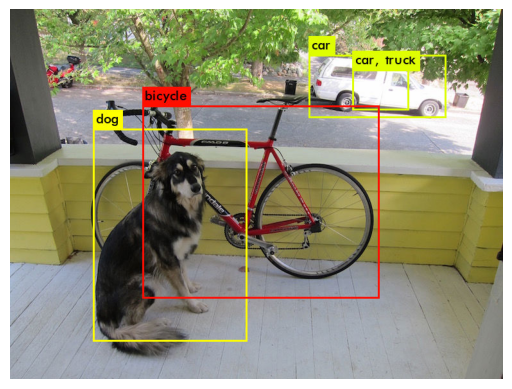

In [14]:
show_prediction('/content/darknet/predictions.jpg')

Lastly, you can also upload custom picture to detect, using either the pretrained or your own model! Upload an image below and see how well it works. Try to experiment and find failure cases with the model. 

In [ ]:
os.chdir("/content")
from google.colab import files

uploaded = files.upload()
os.chdir("/content/darknet/")
!./darknet detect cfg/yolov3-tiny.cfg yolov3-tiny.weights CHANGE_TO_FILE_NAME.jpg